In [1]:
import warnings
warnings.filterwarnings("ignore")

# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

Using TensorFlow backend.


In [2]:
path = "/data/twitter_screenshots/"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
twitter = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.jpg') or file.name.endswith('.png'):
          # adds only the image files to the flowers list
            twitter.append(file.name)

In [3]:
non_path = "/data/randomimage/"
# change the working directory to the path where the images are located
os.chdir(non_path)

# this list holds all the image filename
non_twitter = []

# creates a ScandirIterator aliased as files
with os.scandir(non_path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.jpg') or file.name.endswith('.png'):
          # adds only the image files to the flowers list
            non_twitter.append(file.name)

In [4]:
print(len(non_twitter))
print(len(twitter))

2046
3684


In [5]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

2023-03-29 11:36:24.379829: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-03-29 11:36:24.424147: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa82ea4d250 executing computations on platform Host. Devices:
2023-03-29 11:36:24.424172: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version


In [6]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [7]:
data = {}
labels = {}
# p = r"/Users/duyen/Downloads/twitter_screenshots/twitter_labels.csv"

In [8]:
# lop through each image in the dataset
for t in twitter[:2000]:
    # try to extract the features and update the dictionary
#     try:
        feat = extract_features(path+t,model)
        data[t] = feat
        labels[t] = 1
    # if something fails, save the extracted features as a pickle file (optional)
#     except:
#         with open(p,'wb') as file:
#             pickle.dump(data,file)

In [9]:
# lop through each image in the dataset
for t in non_twitter[:2000]:
    # try to extract the features and update the dictionary
#     try:
        feat = extract_features(non_path+t,model)
        data[t] = feat
        labels[t] = 0
    # if something fails, save the extracted features as a pickle file (optional)
#     except:
#         with open(p,'wb') as file:
#             pickle.dump(data,file)

In [10]:
feat = extract_features(non_path+t,model)

In [11]:
t

'2247.jpg'

In [12]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
print(feat.shape)
# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)
print(feat.shape)

labels_ordered = np.array([labels[t] for t in filenames])
# get the unique labels (from the twitter_labels.csv)
# df = pd.read_csv('twitter_labels.csv')
# label = df['label'].tolist()
# unique_labels = list(set(label))
unique_labels = [0, 1]
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=2, random_state=22)
pca.fit(feat)
x = pca.transform(feat)
# pca_results_0 = [x[0]]
# cluster feature vectors
kmeans = KMeans(n_clusters=len(unique_labels), random_state=22)
kmeans.fit(feat)
clusters = kmeans.labels_


(4000, 1, 4096)
(4000, 4096)


In [13]:
# feat

In [14]:
# labels_ordered

In [15]:
# x

In [16]:
# clusters

In [17]:
results_df = pd.DataFrame({'filename': filenames, 'label': labels_ordered, 'cluster': clusters, 'pca_0': x[:,0], 'pca_1': x[:,1]})

In [18]:
results_df

,filename,label,cluster,pca_0,pca_1
0,@anyuser_1495977824922275840_tweetcapture.png,1,1,13.587862,-16.004702
1,@anyuser_1495977674862387207_tweetcapture.png,1,1,18.786362,-16.521646
2,@anyuser_1495977624665227264_tweetcapture.png,1,1,16.861132,-16.751776
3,@anyuser_1495977945592393729_tweetcapture.png,1,1,22.247906,-10.848243
4,@anyuser_1495977564728442882_tweetcapture.png,1,1,17.424070,-11.992067
...,...,...,...,...,...
3995,225.jpg,0,0,-27.275515,-2.376110
3996,543.jpg,0,0,-30.438408,-1.415193
3997,231.jpg,0,0,-12.960126,1.862466
3998,3159.jpg,0,0,-20.430010,1.514437


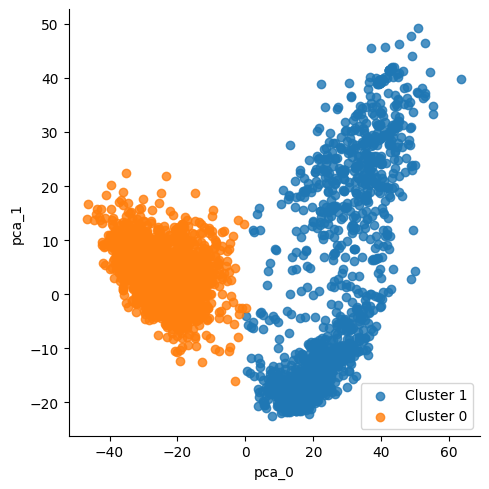

In [19]:
# library & dataset
import seaborn as sns
import matplotlib.pyplot as plt

cluster_str = results_df['cluster'].replace({0: 'Cluster 0', 1: 'Cluster 1'})
results_df_cluster = results_df
results_df_cluster['cluster'] = list(cluster_str)
# give a list to the marker argument
sns.lmplot( x="pca_0", y="pca_1", data=results_df_cluster, fit_reg=False, hue='cluster', legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')

plt.show()

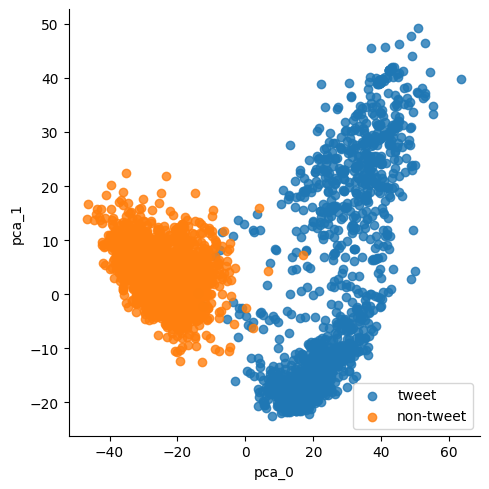

In [20]:
# library & dataset
import seaborn as sns
import matplotlib.pyplot as plt
 
# give a list to the marker argument
labels_str = results_df['label'].replace({0:'non-tweet' , 1: 'tweet'})
results_df_label = results_df
results_df_label['label'] = list(labels_str)
sns.lmplot( x="pca_0", y="pca_1", data=results_df_label, fit_reg=False, hue='label', legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')

plt.show()

In [21]:
results_df.head()

,filename,label,cluster,pca_0,pca_1
0,@anyuser_1495977824922275840_tweetcapture.png,tweet,Cluster 1,13.587862,-16.004702
1,@anyuser_1495977674862387207_tweetcapture.png,tweet,Cluster 1,18.786362,-16.521646
2,@anyuser_1495977624665227264_tweetcapture.png,tweet,Cluster 1,16.861132,-16.751776
3,@anyuser_1495977945592393729_tweetcapture.png,tweet,Cluster 1,22.247906,-10.848243
4,@anyuser_1495977564728442882_tweetcapture.png,tweet,Cluster 1,17.424070,-11.992067


In [22]:
mis_ = []
# a = 0
for i in range(len(results_df)):
#     print(results_df['filename'][i])
    if results_df['label'][i] == 'tweet' and results_df['cluster'][i] == 'Cluster 0':
        mis_.append(results_df['filename'][i])
#         print(results_df['filename'][i])
#         a += 1+
    if results_df['label'][i] == 'non-tweet' and results_df['cluster'][i] == 'Cluster 1':
        mis_.append(results_df['filename'][i])
#         print(results_df['filename'][i])
#         a += 1
print(len(mis_))

19


In [23]:
preds = list(cluster_str.replace({'Cluster 0': 0, 'Cluster 1': 1}))
labels = list(labels_str.replace({'non-tweet': 0, 'tweet': 1}))

In [24]:
import numpy as np
def k_mean_distance(data, cx, cy, i_centroid, cluster_labels):
        distances = [np.sqrt((x-cx)**2+(y-cy)**2) for (x, y) in data[cluster_labels == i_centroid]]
        return distances
centroids = kmeans.cluster_centers_

# calculate distance to each cluster center, 1/distance is used as prob
probs = []
for i in range(len(results_df)):
    x = feat[i]
    prob_dummy = [1/np.linalg.norm(x-c) for c in centroids]
    probs.append(prob_dummy)

In [25]:
probs = np.array(probs)
probs_norm = probs/np.sum(probs, axis=1,keepdims=True)

In [26]:
centroids

array([[0.28206274, 0.49277315, 0.48980796, ..., 0.52988565, 0.54599166,
        0.5140577 ],
       [0.01187088, 0.59320533, 0.08666795, ..., 0.5533104 , 0.00262821,
        1.9279171 ]], dtype=float32)

In [27]:
# preds

In [28]:
# labels

In [29]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

print(
    'ROC AUC Score:', roc_auc_score(labels, preds),
    ', Accuracy Score:', accuracy_score(labels, preds), ', F1 Score:', f1_score(labels, preds)
    , ', Precision Score:', precision_score(labels, preds), ', Recall Score:', recall_score(labels, preds))

ROC AUC Score: 0.9952500000000001 , Accuracy Score: 0.99525 , F1 Score: 0.9952369014790674 , Precision Score: 0.9979889391654098 , Recall Score: 0.9925
